1.
```python
from torch.utils.data import DataLoader, Dataset

count = -123
class OneShotDataset(Dataset):
        
    def __getitem__(self, index):
        global count
        print('i:', index)
        count = index
        return 1
    def __len__(self):
        return 10

dataset_test = OneShotDataset()
data_loader_test = DataLoader(dataset_test, batch_size=128)
for data in data_loader_test:
    print(data)
print(count)
```

2.
```python
classes_data = np.array([[],[],[]])
target = np.array([1,3,2])-1
data = np.array([
    [11,11,11],
    [31,31,31],
    [21,21,21]
])
np.concatenate((classes_data[target], data))
```

- Tutorial from [here](https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7)
- Code [here](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch)
- original paper :[here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) and [here](https://arxiv.org/pdf/1406.4773.pdf)
- Siamese nets were first introduced in the early 1990s by Bromley and LeCun to solve signature verification

additional detail the paper use
- use Regularization
- Early stop if no derease error for 20 epochs
- layerwise learning rate ηj ∈ [10−4
, 10−1
], layer-wise momentum µj ∈ [0, 1], and layer-wise L2 regularization penalty
λj ∈ [0, 0.1]
- Affine distortions (augmented data)
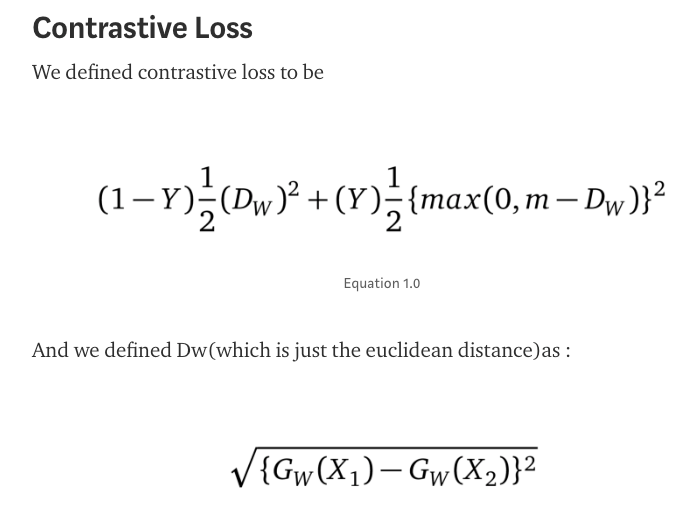

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def random_dict(dict_obj):
    key = random.choice(list(dict_obj))
    return dict_obj[key]
def random_except(arr, except_value):
    random_value = random.choice(arr)
    if random_value == except_value:
        return random_except(arr, except_value)
    return random_value
class OneShotDataset(Dataset):
    
    def __init__(self, dataset, max_num_each_class=10):
        self.class_dict = {}
        self.dataset = dataset
        num_each_class = {}
        self.length = 0
        
        for i, (data, label) in enumerate(self.dataset):
            label_item = label.item()
            if label_item not in list(self.class_dict.keys()):
                self.class_dict[label_item] = []
                num_each_class[label_item] = 0
                
            if max_num_each_class is -1 or num_each_class[label_item] < max_num_each_class:
                self.class_dict[label_item].append((data, label))
                num_each_class[label_item] += 1
                self.length += 1
        
    def __getitem__(self, index):
        image_0, class_0 = random.choice(random_dict(self.class_dict))
        is_same_class = random.randint(0, 1) # to make sure getting images from same class 50%
        if is_same_class:
            class_1_num = class_0.item()
        else:
            class_1_num = random_except(list(self.class_dict), class_0.item())
        image_1, class_1 = random.choice(self.class_dict[class_1_num])
        
        return image_0, image_1, torch.tensor(1-is_same_class, dtype=torch.float32)
    def __len__(self):
        return self.length

In [3]:
# dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transforms.ToTensor()))
# data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=8)
# example_batch = next(iter(data_loader_test))


# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# img = torchvision.utils.make_grid(concatenated)
# img = img.numpy()

# plt.imshow(np.transpose(img, (1, 2, 0)))
# plt.show()
# print(example_batch[2])

In [4]:
transform_train = transforms.Compose([
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = OneShotDataset(datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train))
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transform_test))
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)


In [5]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.Linear(500, 10)
        )
        self.is_classification = True
        
    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    def name(self):
        return "LeNetOneShot"

In [6]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [7]:
criterion = ContrastiveLoss(2)
def model_loss_func(input_data, model, phase):
    image1, image2, is_diff = input_data
    output1, output2 = model(image1, image2)
    loss = criterion(output1, output2, is_diff)
    return (output1, output2), loss

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [8]:
model = LeNetOneShot()

def eval_func(input_data, output, loss):
    _, _, target = input_data
    output1, output2 = output
    euclidean_distance = F.pairwise_distance(output1, output2)
    predict = (euclidean_distance > 1.2).float()
    return predict.eq(target.squeeze()).sum().item()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func)

---- epoch:0 ------
   [train] Average loss: 2.0068, acc: 46.00%
   [test] Average loss: 1.4372, acc: 46.00%
---- epoch:1 ------
   [train] Average loss: 1.1955, acc: 51.00%
   [test] Average loss: 1.0908, acc: 44.00%
---- epoch:2 ------
   [train] Average loss: 0.8320, acc: 58.00%
   [test] Average loss: 0.8132, acc: 69.00%
---- epoch:3 ------
   [train] Average loss: 1.4642, acc: 61.00%
   [test] Average loss: 0.6408, acc: 78.00%
---- epoch:4 ------
   [train] Average loss: 0.6978, acc: 75.00%
   [test] Average loss: 0.7037, acc: 70.00%
---- epoch:5 ------
   [train] Average loss: 0.9516, acc: 66.00%
   [test] Average loss: 0.6414, acc: 74.00%
---- epoch:6 ------
   [train] Average loss: 0.7499, acc: 76.00%
   [test] Average loss: 0.7260, acc: 66.00%
---- epoch:7 ------
   [train] Average loss: 0.6242, acc: 74.00%
   [test] Average loss: 0.7066, acc: 67.00%
---- epoch:8 ------
   [train] Average loss: 0.6375, acc: 70.00%
   [test] Average loss: 0.5906, acc: 73.00%
---- epoch:9 ------

### Finding threshod

In [9]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        _, _, target = input_data
        output1, output2 = output
        euclidean_distance = F.pairwise_distance(output1, output2)
        predict = (euclidean_distance > threshold).float()
        return predict.eq(target.squeeze()).sum().item()
    learner.predict(model_loss_func, eval_func)

In [10]:
for threshold in np.arange(0,3,0.1):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.0
   [test] Average loss: 0.4270, acc: 47.00%
threshold: 0.1
   [test] Average loss: 0.6542, acc: 55.00%
threshold: 0.2
   [test] Average loss: 0.6397, acc: 58.00%
threshold: 0.30000000000000004
   [test] Average loss: 0.6311, acc: 47.00%
threshold: 0.4
   [test] Average loss: 0.5285, acc: 62.00%
threshold: 0.5
   [test] Average loss: 0.4860, acc: 71.00%
threshold: 0.6000000000000001
   [test] Average loss: 0.5788, acc: 62.00%
threshold: 0.7000000000000001
   [test] Average loss: 0.4826, acc: 73.00%
threshold: 0.8
   [test] Average loss: 0.6258, acc: 71.00%
threshold: 0.9
   [test] Average loss: 0.6757, acc: 71.00%
threshold: 1.0
   [test] Average loss: 0.5601, acc: 83.00%
threshold: 1.1
   [test] Average loss: 0.5474, acc: 83.00%
threshold: 1.2000000000000002
   [test] Average loss: 0.5809, acc: 79.00%
threshold: 1.3
   [test] Average loss: 0.6064, acc: 73.00%
threshold: 1.4000000000000001
   [test] Average loss: 0.6535, acc: 72.00%
threshold: 1.5
   [test] Average loss: 

In [11]:
predict_with_threshold(1.4000000000000001)

   [test] Average loss: 0.5451, acc: 84.00%
